#  Digit Recognizer

# Model Engineering

## 1 - Introduction

> The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.  As the competition progresses, we will release tutorials which explain different machine learning algorithms and help you to get started.

> The data for this competition were taken from the MNIST dataset. The MNIST ("Modified National Institute of Standards and Technology") dataset is a classic within the Machine Learning community that has been extensively studied.  More detail about the dataset, including Machine Learning algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html.


## 2 - Setup

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
%matplotlib inline

In [2]:
project_dir = os.path.join(os.path.dirname('__file__'), os.pardir)
settings = json.loads(open(os.path.join(project_dir, 'SETTINGS.json')).read())
train_path = os.path.join(project_dir, settings['TRAIN_DATA_PATH'])
test_path = os.path.join(project_dir, settings['TEST_DATA_PATH'])

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print(train_data.shape)
print(test_data.shape)

(42000, 785)
(28000, 784)


As discribed on Kaggle's website:

> Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

> The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

> Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).


The image bellow shows a sample of data from train dataset.

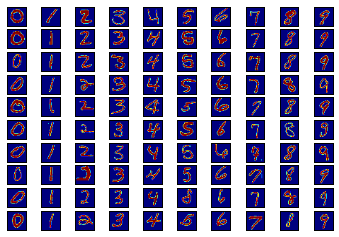

In [3]:
f, axarr = plt.subplots(10, 10)
for row in range(10):
    for column in range(10):
        entry = train_data[train_data['label']==column].iloc[row].drop('label').as_matrix()
        axarr[row, column].imshow(entry.reshape([28, 28]))
        axarr[row, column].get_xaxis().set_visible(False)
        axarr[row, column].get_yaxis().set_visible(False)

# 3 - Logistic Regression

The first model, that will serve as a benchmark, will be [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). We use [tensorflow](https://www.tensorflow.org) in order to get a well suited model.


## 3.1 - Model

First we will define the placeholder for input x. Then we define the weights and biases of our model as Variables. Finally we will define our Logist Regression model.

In [4]:
# input tensor
x = tf.placeholder(tf.float32, [None, 784])

# weights (w) and biases (s) 
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# model output (y)
y = tf.nn.softmax(tf.matmul(x, W) + b)

## 3.1 - Training

First we will define the placeholder for the targets of our train data. Then the cross entropy can be calculated as follows:

In [5]:
# target
y_ = tf.placeholder(tf.float32, [None, 10])
# cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

We will describe bellow the train step and the accuracy mesure of the model.

In [6]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In order to train teh model we first need to initialize all variables. Second we will iterate over many epochs and evaluate the model using a train and test set.

In [14]:
train_val_ratio = 0.7
train_data_size = len(train_data)
train_set = train_data[:int(train_data_size*train_val_ratio)]
val_set = train_data[int(train_data_size*train_val_ratio)+1:]

init = tf.initialize_all_variables()
saver = tf.train.Saver()
sess = tf.Session()
sess.run(init)

train_eval_list = []
val_eval_list = []
for i in range(1000):
    batch = train_set.sample(frac=0.1)
    batch_xs = batch.drop('label', axis=1).as_matrix()/255.0
    batch_ys = pd.get_dummies(batch['label']).as_matrix()
    val_xs = val_set.drop('label', axis=1).as_matrix()/255.0
    val_ys = pd.get_dummies(val_set['label']).as_matrix()

    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
 
    train_eval = sess.run(accuracy, feed_dict={x: batch_xs, y_: batch_ys})
    val_eval = sess.run(accuracy, feed_dict={x: val_xs, y_: val_ys})
    
    train_eval_list.append(train_eval)
    val_eval_list.append(val_eval)
# 

## 3.2 - Evaluation

As we can see the training did not overfit. So it is ready to be aplied to the test data.

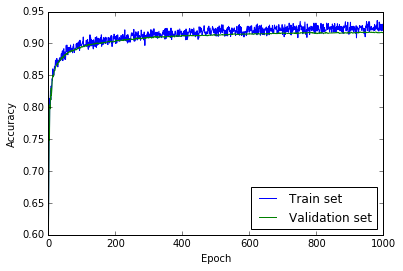

In [15]:
plt.plot(train_eval_list, label='Train set')
plt.plot(val_eval_list, label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)

The following cell runs the model on the test data and generates a CSV file for Kaggle's submission. This submission scores 0.91714. That is not a particularly good result for MNIST, where the state of art can score over 0.99. We will work on other models to try to get closer to this score.

In [16]:
predict = sess.run(y, feed_dict={x: test_data.as_matrix() / 255.0})
pred = [[i + 1, np.argmax(one_hot_list)] for i, one_hot_list in enumerate(predict)]
submission = pd.DataFrame(pred, columns=['ImageId', 'Label'])
submission_path = os.path.join(project_dir, settings['SUBMISSION_PATH'], 'logistic_regression.csv')
submission.to_csv(submission_path, index=False)

To keep this trained model for further use, we can just save the session.

In [17]:
model_path = os.path.join(project_dir, settings['MODEL_PATH'], "logistic_regression.ckpt")
saver.save(sess, model_path)
sess.close()